# Семинар/ДЗ №2: введение в нейронные сети

Имя, Фамилия: Карпович Лидия

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

from typing import Callable, Any
import tqdm.auto as tqdm

seed = 47
np.random.seed(seed)

%matplotlib inline

## Загружаем выборку Diamonds

Описание данных:

1. **PRICE**: price in US dollars (326-18,823)
2. **CARAT**: weight of the diamond (0.2--5.01)
3. **CUT**: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. **COLOR**: diamond colour, from J (worst) to D (best)
5. **CLARITY**: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. **X**: length in mm (0--10.74)
7. **Y**: width in mm (0--58.9)
8. **Z**: depth in mm (0--31.8)
9. **DEPTH**: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. **TABLE**: width of top of diamond relative to widest point (43--95)

Скачиваем данные с гугл-диска:


In [3]:
!gdown "10DwRuHOTWWFm3DXXok7vad0vKgzRp7pS"

Downloading...
From: https://drive.google.com/uc?id=10DwRuHOTWWFm3DXXok7vad0vKgzRp7pS
To: /content/diamonds.csv
100% 3.19M/3.19M [00:00<00:00, 30.6MB/s]


In [4]:
df = pd.read_csv('/content/diamonds.csv').drop(columns=['Unnamed: 0'])
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


## Подготовка данных и их анализ

Преобразуем категориальные признаки

In [5]:
categorial_features = ['cut', 'clarity', 'color']

ct = ColumnTransformer(
       transformers=[
           ('ordinal', OrdinalEncoder(), categorial_features)
       ],
       remainder='passthrough',
       verbose_feature_names_out=False
   )

encoded = ct.fit_transform(df)
df = pd.DataFrame(encoded, columns=ct.get_feature_names_out())
df

,cut,clarity,color,carat,depth,table,price,x,y,z
0,2.0,3.0,1.0,0.23,61.5,55.0,326.0,3.95,3.98,2.43
1,3.0,2.0,1.0,0.21,59.8,61.0,326.0,3.89,3.84,2.31
2,1.0,4.0,1.0,0.23,56.9,65.0,327.0,4.05,4.07,2.31
3,3.0,5.0,5.0,0.29,62.4,58.0,334.0,4.20,4.23,2.63
4,1.0,3.0,6.0,0.31,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,2.0,2.0,0.0,0.72,60.8,57.0,2757.0,5.75,5.76,3.50
53936,1.0,2.0,0.0,0.72,63.1,55.0,2757.0,5.69,5.75,3.61
53937,4.0,2.0,0.0,0.70,62.8,60.0,2757.0,5.66,5.68,3.56
53938,3.0,3.0,4.0,0.86,61.0,58.0,2757.0,6.15,6.12,3.74


In [6]:
ct.transformers_[0]

('ordinal', OrdinalEncoder(), ['cut', 'clarity', 'color'])

In [7]:
ct.transformers_[0][1].categories_

[array(['Fair', 'Good', 'Ideal', 'Premium', 'Very Good'], dtype=object),
 array(['I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2'],
       dtype=object),
 array(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object)]

Анализ полученных данных

In [8]:
def get_pretty_title(text: str) -> str:
    return ('\033[1m' + text + '\033[0m').center(55)

def pretty_print(text: str, values: Any):
    print(f'\n\n{get_pretty_title(text)}', values, sep='\n\n')

def analysis(data: pd.DataFrame,
             target_name: str,
             numerical_features: list[str]):

    pretty_print('Типы данных:', data.dtypes)
    pretty_print('Описательные статистики:', data.describe())
    pretty_print('Пропуски в данных:', data.isna().sum())
    pretty_print('Количество дубликатов:', data.duplicated().sum())

    print(f'\n\n{get_pretty_title("Распределение целевой переменной")}\n')

    plt.figure(figsize=[6, 5])
    plt.hist(df[target_name], bins=100)
    plt.grid()
    plt.show()

In [9]:
target = ['price']
numerical_features = [col
                      for col in list(df.columns)
                      if col not in categorial_features + target]
numerical_features

['carat', 'depth', 'table', 'x', 'y', 'z']



                  Типы данных:                 

cut        float64
clarity    float64
color      float64
carat      float64
depth      float64
table      float64
price      float64
x          float64
y          float64
z          float64
dtype: object


            Описательные статистики:           

                cut       clarity         color         carat         depth  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       2.553003      3.835150      2.594197      0.797940     61.749405   
std        1.027708      1.724591      1.701105      0.474011      1.432621   
min        0.000000      0.000000      0.000000      0.200000     43.000000   
25%        2.000000      2.000000      1.000000      0.400000     61.000000   
50%        2.000000      4.000000      3.000000      0.700000     61.800000   
75%        3.000000      5.000000      4.000000      1.040000     62.500000   
max        4.000000      7.000000      6.000000      5.010000 

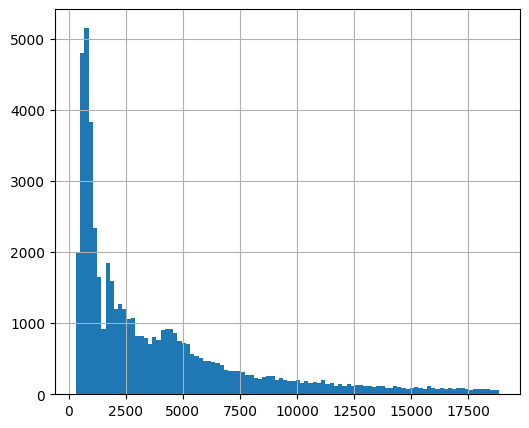

In [10]:
analysis(df, target_name=target[0], numerical_features=numerical_features)

In [11]:
df = df.drop_duplicates()

In [12]:
X = df.drop(columns=target).copy().values
y = df[target].copy().values

In [13]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.3)

## Обучаем модель линейной регрессии

In [15]:
reg = LinearRegression().fit(X_train, y_train)

In [16]:
y_pred = reg.predict(X_test)

In [17]:
score = r2_score(y_pred, y_test)

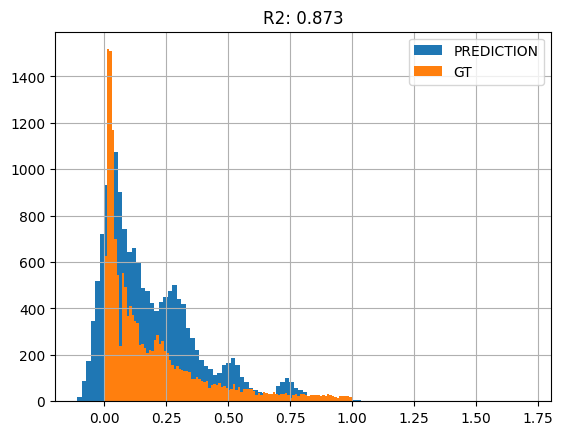

In [18]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

Посмотрим, как справится нейронная сеть

## Задание 1: реализация слоев нейронной сети (3 балла)

Реализуйте следующие слои:


1.   Линейный слой (1 балл)
2.   Функция активации: ReLU (1 балл)
3.   Функция активации: Tanh (1 балл)

В линейном слое на методы прямого и обратных проходов навешаны декораторы: они понадобятся для следующего задания.



In [19]:
class Module:
    """
    Базовый класс для построения модулей нейронной сети.

    Attributes:
        forward_hook (Callable): Функция, которая будет вызываться после
                                 вычисления прямого прохода.

        backward_hook (Callable): Функция, которая будет вызываться после
                                  вычисления обратного прохода.

    Notes:
        Этот класс является абстрактным и не должен использоваться напрямую.
        Он предназначен для создания конкретных модулей нейронной сети, которые
        наследуются от него и реализуют необходимые методы.
    """

    def __init__(self):
        self.forward_hook = None
        self.backward_hook = None

    def register_forward_hook(self, forward_hook: Callable):
        """
        Метод для регистрации forward_hook
        """

        self.forward_hook = forward_hook

    def register_backward_hook(self, backward_hook: Callable):
        """
        Метод для регистрации backward_hook
        """

        self.backward_hook = backward_hook

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Метод для прямого прохода

        Args:
            x (np.ndarray): Входные данные. Размерность может быть (batch_size,
              in_features) или (in_features,) для вектора.

        Returns:
            np.ndarray: Выходные данные после линейного преобразования
            (размерность: (batch_size, out_features) или (out_features,) для вектора).
        """
        pass

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        """
        Метод для обратного прохода

        Args:
            gradient (np.ndarray): Градиент ошибки, полученный от следующего слоя.
            Размерность может быть (batch_size, out_features) или (out_features,)
            для вектора.

        Returns:
            np.ndarray: Градиент ошибки для предыдущего слоя
            (размерность: (batch_size, in_features) или (in_features,) для вектора).
        """
        pass

    def update(self, learning_rate: float) -> None:
        """
        Метод для обновления параметров модуля

        Args:
            learning_rate (float): Скорость обучения.
        """
        pass

Функции для расчета стандартного отклонения при прямом и обратных проходах

In [20]:
def forward_hook(input_, output):
    std = input_.std().item()
    print('forward', std)

def backward_hook(grad_input, grad_output):
    std = grad_input.std().item()
    print('\tbackward', std)

def execute_hook(hook: Callable) -> Callable:
    def decorator(func: Callable) -> Callable:
        def wrapper(self, x: Any) -> Any:
            output = func(self, x)
            hook(x, output)
            return output
        return wrapper
    return decorator

In [21]:
class Linear(Module):
    """
    Реализует полносвязный линейный слой.

    Этот слой выполняет линейное преобразование входных данных: y = xW + b,
    где W - матрица весов, b - вектор смещения, а x - входные данные.

    Args:
        in_features (int): Количество входных признаков.
        out_features (int): Количество выходных признаков.
    """

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = np.zeros(out_features)
        self.weight = np.random.randn(in_features, out_features) * 0.01
        self.dW = np.zeros_like(self.weight)
        self.db = np.zeros_like(self.bias)


    @execute_hook(hook=forward_hook)
    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return x @ self.weight + self.bias


    @execute_hook(hook=backward_hook)
    def backward(self, gradient: np.ndarray) -> np.ndarray:
        self.dW[:] = self.input.T @ gradient
        self.db[:] = gradient.sum(axis=0)
        return gradient @ self.weight.T


    def update(self, learning_rate: float) -> None:
        self.weight -= learning_rate * self.dW
        self.bias -= learning_rate * self.db

In [22]:
class ReLU(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return np.maximum(0, x)

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        return gradient * (self.input > 0)

In [23]:
class Tanh(Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        return np.tanh(x)

    def backward(self, gradient: np.ndarray) -> np.ndarray:
        return gradient * (1 - np.tanh(self.input) ** 2)

## Задание 2: начальная инициализация (3 балла)

Необходимо реализовать следующие подходы к иницализации нейронной сети:

1. Инициализация случайными числами из нормального распределения (1 балл)
$$\mathbb{N}(0, \frac{1}{n_{in}})$$


2. Инициализация Xavier Glorot (1 балл)
$$U \left[ - \frac{\sqrt{6}}{\sqrt{n_{in}+n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in}+n_{out}}}  \right ] $$


3. Инициализация Kaiming He (1 балл)
$$\mathbb{N}(0, \frac{2}{n_{in}})$$



In [24]:
def init_layer(layer: Module) -> None:
    """
    Инициализирует веса и смещение.

    Args:
        layer (Module): Экземпляр слоя, который необходимо инициализировать.

    Returns:
        None. Функция изменяет слой layer in-place.
    """
    layer.weight = np.random.randn(layer.in_features, layer.out_features)
    layer.bias = np.zeros(layer.out_features)

In [25]:
def init_layer_norm(layer: Module) -> None:
    layer.weight = np.random.randn(layer.in_features, layer.out_features)
    layer.bias = np.zeros(layer.out_features)

In [26]:
def init_layer_xavier(layer: Module) -> None:
    limit = np.sqrt(6 / (layer.in_features + layer.out_features))
    layer.weight = np.random.uniform(-limit, limit, size=(layer.in_features, layer.out_features))
    layer.bias = np.zeros(layer.out_features)

In [27]:
def init_layer_kaiming(layer: Module) -> None:
    std_dev = np.sqrt(2 / layer.in_features)
    layer.weight = np.random.randn(layer.in_features, layer.out_features) * std_dev
    layer.bias = np.zeros(layer.out_features)

## Задание 3: MLP для задачи регрессии (4 балла)

Необходимо реализовать модель MLP для задачи регресcии

Для визуализации процесса обучения рекомендуется использовать модуль `tqdm`

In [28]:
class MLPRegressor:
    """
    Класс MLP для задач регрессии.
    """
    def __init__(self,
                 init_func: Callable,
                 hidden_layer_sizes: tuple,
                 batch_size: int,
                 learning_rate: float,
                 max_iter: int):

        self.init_func = init_func
        self.hidden_layer_sizes = hidden_layer_sizes
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.layers = []

    def __customize_layer(self, layer):
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        self.init_func(layer)
        return layer

    def build_network(self, input_dim: int, output_dim: int):
        """Создает архитектуру MLP."""
        layer_sizes = [input_dim] + list(self.hidden_layer_sizes) + [output_dim]

        for i in range(len(layer_sizes) - 1):
            self.layers.append(self.__customize_layer(Linear(layer_sizes[i], layer_sizes[i + 1])))
            if i < len(layer_sizes) - 2:
                self.layers.append(ReLU())

    def forward(self, X: np.ndarray) -> np.ndarray:
        """Выполняет прямой проход."""
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, loss_grad: np.ndarray):
        """Выполняет обратный проход."""
        for layer in reversed(self.layers):
            loss_grad = layer.backward(loss_grad)

    def update_weights(self):
        """Обновляет веса всех слоев."""
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.update(self.learning_rate)

    def train(self, X: np.ndarray, y: np.ndarray) -> None:
        """Обучает модель."""
        num_samples = X.shape[0]

        for epoch in tqdm(range(self.max_iter), desc="Training Progress", leave=True):
            indices = np.random.permutation(num_samples)
            X_shuffled, y_shuffled = X[indices], y[indices]

            for i in range(0, num_samples, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]

                y_pred = self.forward(X_batch)
                loss = np.mean((y_pred - y_batch) ** 2)
                loss_grad = 2 * (y_pred - y_batch) / y_batch.shape[0]

                self.backward(loss_grad)
                self.update_weights()

            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Делает предсказание."""
        return self.forward(X)


Проверяем модель MLP на выборке Diamonds

In [30]:
from tqdm.auto import tqdm

mlp = MLPRegressor(init_func=init_layer_xavier,
                   hidden_layer_sizes=(64, 32),
                   batch_size=32,
                   learning_rate=0.01,
                   max_iter=5)

mlp.build_network(input_dim=X_train.shape[1], output_dim=1)
mlp.train(X_train, y_train)

y_pred = mlp.predict(X_test)
mse = np.mean((y_pred - y_test) ** 2)
print(f"Mean Squared Error on Test Set: {mse:.4f}")

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
forward 0.11880406443878944
	backward 0.00319153340953249
	backward 0.0007188269154109637
	backward 0.0005597986609130117
forward 0.25061040812113017
forward 0.13583720452036976
forward 0.11841420536828838
	backward 0.00618745186448555
	backward 0.0013960164994254295
	backward 0.0011169912861607942
forward 0.2568541552675451
forward 0.14018265993294932
forward 0.11980389054552734
	backward 0.004975984996211741
	backward 0.001124009379090721
	backward 0.000888973331151899
forward 0.2649766190527207
forward 0.14424408345815085
forward 0.11947415554598811
	backward 0.003214587645603484
	backward 0.0007536475235691225
	backward 0.0005902399433525338
forward 0.252295900022821
forward 0.14059091537244364
forward 0.11697743707471973
	backward 0.003066125841129369
	backward 0.0007262169741597205
	backward 0.000577337542956057
forward 0.262129476976071
forward 0.14729617729117497
forward 0.1202962226697314
	backward 0.004580027

# Домашнее задание № 2

Выполните задания в этом ноутбуке, а также:

1. Сравните подходы к начальной инициализации весов нейронной сети. В качестве ответа ожидается текстовое описание проведенного анализа и полученных выводов.

    *Подсказка: с помощью предложенных декораторов понаблюдайте за выходами слоев при обучении как при прямом, так и при обратном проходах. Удобнее это сделать на одном линейном слое.*

2. Сравните различные архитектуры моделей, экспериментируйте с размерами
слоев, их количеством, функциями активации, а также подходами к инициализации и гиперпараметрами. Подберите лучшую связку, дающую наивысшую целевую метрику.

    В качестве ответа приведите описание проведенных вами экспериментов и выводы из них *(не обязательно, чтобы все эксперименты были удачными, нужно чтобы из каждого был извлечен полезный опыт)*

ВАЖНО: при отсутствии анализа (только за реализацию) баллы не начисляются.

+ Мягкий дедлайн: `05.02.25 23:59`
+ Жесткий дедлайн: `12.02.25 23:59` (половина баллов)


После жесткого дедлайна задание не принимается.

In [ ]:
from tqdm.auto import tqdm


def run_experiment(init_func, hidden_layers, activation, learning_rate, batch_size, max_iter, X_train, y_train, X_test, y_test):
    mlp = MLPRegressor(init_func=init_func,
                        hidden_layer_sizes=hidden_layers,
                        batch_size=batch_size,
                        learning_rate=learning_rate,
                        max_iter=max_iter)

    mlp.build_network(input_dim=X_train.shape[1], output_dim=1)
    mlp.train(X_train, y_train)

    y_pred = mlp.predict(X_test)
    mse = np.mean((y_pred - y_test) ** 2)
    return mse

initializations = [init_layer_norm, init_layer_xavier, init_layer_kaiming]
activations = [ReLU, Tanh]
layer_configs = [(32,), (64, 32), (128, 64, 32)]
learning_rates = [0.01, 0.001]
batch_sizes = [16, 32]

results = []

for init in initializations:
    for activation in activations:
        for layers in layer_configs:
            for lr in learning_rates:
                for batch in batch_sizes:
                    mse = run_experiment(init, layers, activation, lr, batch, 5, X_train, y_train, X_test, y_test)
                    results.append((init.__name__, activation.__name__, layers, lr, batch, mse))


results.sort(key=lambda x: x[-1])
for res in results:
    print(f"Init: {res[0]}, Act: {res[1]}, Layers: {res[2]}, LR: {res[3]}, Batch: {res[4]}, MSE: {res[5]:.4f}")


inits = [r[0] for r in results]
mse_values = [r[-1] for r in results]
plt.figure(figsize=(12, 6))
plt.barh(inits, mse_values)
plt.xlabel("Mean Squared Error")
plt.ylabel("Initialization Method")
plt.title("Comparison of Weight Initialization Methods")
plt.show()




1.   init_layer_kaiming, Act: ReLU, Layers: (128, 64, 32), LR: 0.01, Batch: 16, MSE: 0.0029
2.   init_layer_kaiming, Act: Tanh, Layers: (128, 64, 32), LR: 0.01, Batch: 16, MSE: 0.0030
3.   init_layer_xavier, Act: ReLU, Layers: (128, 64, 32), LR: 0.01, Batch: 16, MSE: 0.0030
4.   init_layer_xavier, Act: Tanh, Layers: (128, 64, 32), LR: 0.01, Batch: 16, MSE: 0.0031
5.   init_layer_kaiming, Act: ReLU, Layers: (128, 64, 32), LR: 0.01, Batch: 32, MSE: 0.0033
6.   init_layer_xavier, Act: Tanh, Layers: (128, 64, 32), LR: 0.01, Batch: 32, MSE: 0.0034
7.   init_layer_kaiming, Act: Tanh, Layers: (128, 64, 32), LR: 0.01, Batch: 32, MSE: 0.0036
8.   init_layer_kaiming, Act: Tanh, Layers: (64, 32), LR: 0.01, Batch: 16, MSE: 0.0039
9.   init_layer_xavier, Act: Tanh, Layers: (64, 32), LR: 0.01, Batch: 16, MSE: 0.0040
10.  init_layer_kaiming, Act: ReLU, Layers: (64, 32), LR: 0.01, Batch: 16, MSE: 0.0042
11.  init_layer_kaiming, Act: Tanh, Layers: (128, 64, 32), LR: 0.001, Batch: 16, MSE: 0.0047
12.  init_layer_xavier, Act: Tanh, Layers: (64, 32), LR: 0.01, Batch: 32, MSE: 0.0047
13.   init_layer_kaiming, Act: ReLU, Layers: (64, 32), LR: 0.01, Batch: 32, MSE: 0.0049
14.   init_layer_xavier, Act: Tanh, Layers: (32,), LR: 0.01, Batch: 16, MSE: 0.0055
15. init_layer_kaiming, Act: Tanh, Layers: (64, 32), LR: 0.01, Batch: 32, MSE: 0.0055
16. init_layer_kaiming, Act: ReLU, Layers: (32,), LR: 0.01, Batch: 32, MSE: 0.0057
17. init_layer_kaiming, Act: Tanh, Layers: (32,), LR: 0.01, Batch: 32, MSE: 0.0058
18. init_layer_kaiming, Act: Tanh, Layers: (32,), LR: 0.01, Batch: 16, MSE: 0.0059
19. init_layer_kaiming, Act: ReLU, Layers: (32,), LR: 0.01, Batch: 16, MSE: 0.0063
20. init_layer_kaiming, Act: Tanh, Layers: (64, 32), LR: 0.001, Batch: 16, MSE: 0.0065
21. init_layer_kaiming, Act: Tanh, Layers: (128, 64, 32), LR: 0.001, Batch: 32, MSE: 0.0065
22. init_layer_xavier, Act: Tanh, Layers: (32,), LR: 0.01, Batch: 32, MSE: 0.0066
23. init_layer_kaiming, Act: ReLU, Layers: (128, 64, 32), LR: 0.001, Batch: 16, MSE: 0.0070
24. init_layer_norm, Act: ReLU, Layers: (32,), LR: 0.01, Batch: 32, MSE: 0.0076
25. init_layer_norm, Act: ReLU, Layers: (32,), LR: 0.01, Batch: 16, MSE: 0.0076
26. init_layer_kaiming, Act: ReLU, Layers: (64, 32), LR: 0.001, Batch: 16, MSE: 0.0076
27. init_layer_kaiming, Act: ReLU, Layers: (64, 32), LR: 0.001, Batch: 32, MSE: 0.0083
28. init_layer_xavier, Act: Tanh, Layers: (128, 64, 32), LR: 0.001, Batch: 16, MSE: 0.0084
29. init_layer_kaiming, Act: ReLU, Layers: (128, 64, 32), LR: 0.001, Batch: 32, MSE: 0.0085
30. init_layer_kaiming, Act: Tanh, Layers: (64, 32), LR: 0.001, Batch: 32, MSE: 0.0116
31. init_layer_kaiming, Act: ReLU, Layers: (32,), LR: 0.001, Batch: 16, MSE: 0.0120
32. init_layer_norm, Act: Tanh, Layers: (32,), LR: 0.001, Batch: 16, MSE: 0.0128
33. init_layer_kaiming, Act: Tanh, Layers: (32,), LR: 0.001, Batch: 32, MSE: 0.0152
34. init_layer_xavier, Act: Tanh, Layers: (64, 32), LR: 0.001, Batch: 16, MSE: 0.0153
35. init_layer_xavier, Act: Tanh, Layers: (64, 32), LR: 0.001, Batch: 32, MSE: 0.0160
36. init_layer_xavier, Act: Tanh, Layers: (128, 64, 32), LR: 0.001, Batch: 32, MSE: 0.0166
37. init_layer_xavier, Act: Tanh, Layers: (32,), LR: 0.001, Batch: 32, MSE: 0.0172
38. init_layer_norm, Act: ReLU, Layers: (64, 32), LR: 0.001, Batch: 16, MSE: 0.0177
39. init_layer_xavier, Act: Tanh, Layers: (32,), LR: 0.001, Batch: 16, MSE: 0.0189
40. init_layer_kaiming, Act: ReLU, Layers: (32,), LR: 0.001, Batch: 32, MSE: 0.0191
41. init_layer_norm, Act: ReLU, Layers: (32,), LR: 0.001, Batch: 32, MSE: 0.0192
42. init_layer_norm, Act: ReLU, Layers: (32,), LR: 0.001, Batch: 16, MSE: 0.0197
43. init_layer_norm, Act: ReLU, Layers: (64, 32), LR: 0.01, Batch: 16, MSE: nan
44. init_layer_norm, Act: ReLU, Layers: (64, 32), LR: 0.01, Batch: 32, MSE: nan
45. init_layer_kaiming, Act: Tanh, Layers: (32,), LR: 0.001, Batch: 16, MSE: 0.0201
46. init_layer_norm, Act: ReLU, Layers: (64, 32), LR: 0.001, Batch: 32, MSE: 0.0367
47. init_layer_norm, Act: ReLU, Layers: (128, 64, 32), LR: 0.01, Batch: 16, MSE: nan
48. init_layer_norm, Act: ReLU, Layers: (128, 64, 32), LR: 0.01, Batch: 32, MSE: nan
49. init_layer_norm, Act: ReLU, Layers: (128, 64, 32), LR: 0.001, Batch: 16, MSE: nan
50. init_layer_norm, Act: ReLU, Layers: (128, 64, 32), LR: 0.001, Batch: 32, MSE: nan
51. init_layer_xavier, Act: ReLU, Layers: (64, 32), LR: 0.01, Batch: 16, MSE: 0.0037
52. init_layer_xavier, Act: ReLU, Layers: (128, 64, 32), LR: 0.01, Batch: 32, MSE: 0.0039
53. init_layer_xavier, Act: ReLU, Layers: (64, 32), LR: 0.01, Batch: 32, MSE: 0.0043
54. init_layer_xavier, Act: ReLU, Layers: (32,), LR: 0.01, Batch: 16, MSE: 0.0044
55. init_layer_xavier, Act: ReLU, Layers: (32,), LR: 0.01, Batch: 32, MSE: 0.0065
56. init_layer_norm, Act: Tanh, Layers: (32,), LR: 0.01, Batch: 16, MSE: 0.0079
57. init_layer_norm, Act: Tanh, Layers: (32,), LR: 0.01, Batch: 32, MSE: 0.0085
58. init_layer_xavier, Act: ReLU, Layers: (64, 32), LR: 0.001, Batch: 16, MSE: 0.0089
59. init_layer_xavier, Act: ReLU, Layers: (128, 64, 32), LR: 0.001, Batch: 16, MSE: 0.0097
60. init_layer_norm, Act: Tanh, Layers: (32,), LR: 0.001, Batch: 32, MSE: 0.0517
61. init_layer_norm, Act: Tanh, Layers: (64, 32), LR: 0.01, Batch: 16, MSE: nan
62. init_layer_norm, Act: Tanh, Layers: (64, 32), LR: 0.01, Batch: 32, MSE: nan
63. init_layer_norm, Act: Tanh, Layers: (64, 32), LR: 0.001, Batch: 16, MSE: 0.0139
64. init_layer_norm, Act: Tanh, Layers: (64, 32), LR: 0.001, Batch: 32, MSE: 0.0530
65. init_layer_norm, Act: Tanh, Layers: (128, 64, 32), LR: 0.01, Batch: 16, MSE: nan
66. init_layer_norm, Act: Tanh, Layers: (128, 64, 32), LR: 0.01, Batch: 32, MSE: nan
67. init_layer_norm, Act: Tanh, Layers: (128, 64, 32), LR: 0.001, Batch: 16, MSE: nan
68. init_layer_norm, Act: Tanh, Layers: (128, 64, 32), LR: 0.001, Batch: 32, MSE: nan
69. init_layer_xavier, Act: ReLU, Layers: (32,), LR: 0.001, Batch: 16, MSE: 0.0149
70. init_layer_xavier, Act: ReLU, Layers: (128, 64, 32), LR: 0.001, Batch: 32, MSE: 0.0196
71. init_layer_xavier, Act: ReLU, Layers: (32,), LR: 0.001, Batch: 32, MSE: 0.0214
72. init_layer_xavier, Act: ReLU, Layers: (64, 32), LR: 0.001, Batch: 32, MSE: 0.0222


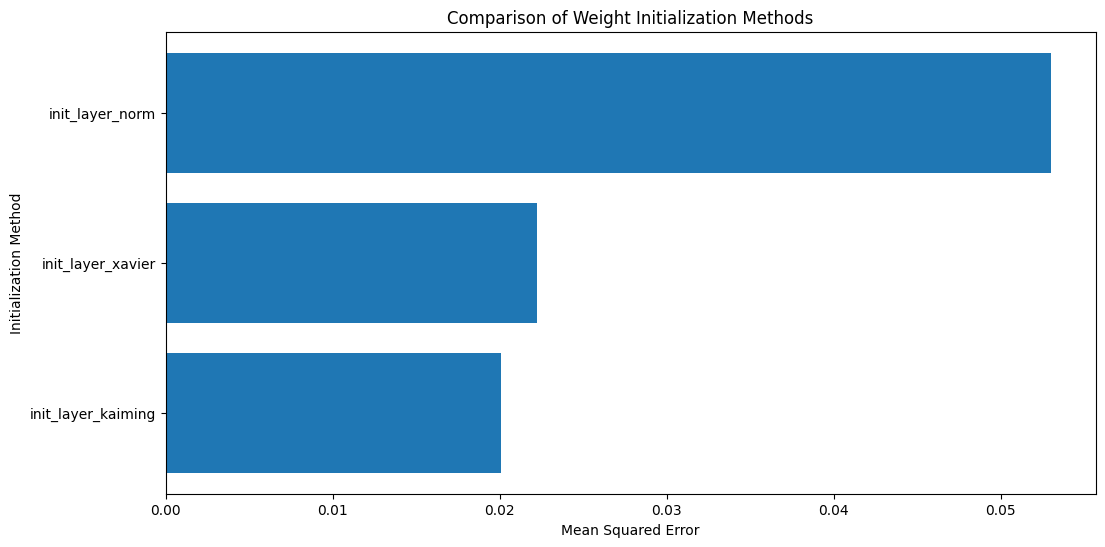

Анализ влияния инициализации, функций активации, архитектуры и гиперпараметров на качество MLP

1. В ходе экспериментов были протестированы различные методы инициализации весов, функции активации, архитектуры нейросетей и гиперпараметры (learning rate, batch size) на задаче регрессии. Оценка проводилась по метрике MSE. Обучение моделей проводилось на малом количестве эпох (5).

2. Рассмотренные методы инициализации:

*   Kaiming (He) – адаптирован для ReLU
*   Xavier (Glorot) – универсальный метод
*   Нормальная (init_layer_norm) – простая случайная инициализация

Выводы:

Kaiming (He) показал наилучшие результаты при использовании с ReLU, что логично, так как он был разработан специально для таких функций активации.

Xavier показал хорошие результаты с Tanh и ReLU, но немного уступал Kaiming.

init_layer_norm часто приводил к большим MSE или NaN – вероятно, веса оказывались слишком большими, вызывая проблемы в градиентном спуске.

3. Рассматривались две функции активации:

*   ReLU (Rectified Linear Unit)
*   Tanh (Гиперболический тангенс)

Выводы:

ReLU в сочетании с Kaiming He дала лучший MSE (0.0029).

Tanh показал немного худший результат, но работал стабильно.

ReLU может приводить к появлению NaN, если learning rate слишком большой.

4. Исследовались разные конфигурации слоев:

(128, 64, 32) – наилучший результат (MSE ~ 0.0029)

(64, 32) – средние результаты (MSE ~ 0.0039 - 0.0042)

(32,) – слабый результат (MSE > 0.005)

Выводы:

Глубокая сеть (128, 64, 32) работает лучше, чем мелкие архитектуры.

Маленькие сети (32,) сильно уступают по точности.

5. Влияние гиперпараметров (LR, Batch Size)

Learning rate 0.01 давал лучшие результаты (если не было NaN).

Learning rate 0.001 снижал точность, но предотвращал ошибки NaN.

Batch size 16 давал лучшие результаты, чем 32.

6. Почему появились NaN?

NaN возникали в init_layer_norm, особенно при больших LR (0.01).

Возможно, веса имели слишком большие начальные значения, вызывая переполнение градиентов.

Вывод

Правильная инициализация весов и выбор архитектуры критически важны для точности модели. Kaiming He + ReLU + (128, 64, 32) + LR 0.01 показали наилучшие результаты.